In [11]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD, Adam, RMSprop
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.user_embedding_mf = nn.Embedding(nb_users, mf_dim)
        self.item_embedding_mf = nn.Embedding(nb_items, mf_dim)

        self.user_embedding_mlp = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.item_embedding_mlp = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        mlp_layers = []
        input_size = mlp_layer_sizes[0]
        for layer_size in mlp_layer_sizes[1:]:
            mlp_layers.append(nn.Linear(input_size, layer_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_layers)
        self.final = nn.Linear(mf_dim + mlp_layer_sizes[-1], 1)
        
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn
        self._init_weights()
        
    def _init_weights(self):
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)
            
        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
            
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        user_embedding_mf = self.user_embedding_mf(user)
        item_embedding_mf = self.item_embedding_mf(item)
        user_embedding_mlp = self.user_embedding_mlp(user)
        item_embedding_mlp = self.item_embedding_mlp(item)
        
        mf_output = user_embedding_mf * item_embedding_mf
        
        mlp_input = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)
        mlp_output = self.mlp(mlp_input)
        
        concat_output = torch.cat((mf_output, mlp_output), dim=-1)
        
        output = self.final(concat_output)
        if sigmoid:
            output = torch.sigmoid(output)
        
        return output

In [4]:
if __name__ == "__main__":
    nb_users = 1000
    nb_items = 1700
    mf_dim = 10
    mlp_layer_sizes = [64, 32, 16, 8]

    model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
    user_id = torch.tensor([1])
    item_id = torch.tensor([10])
    output = model(user_id, item_id, sigmoid=True)
    print(output)

tensor([[0.2548]], grad_fn=<SigmoidBackward0>)


### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [5]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        all_items = set(range(1, max_item + 1))
        user_item_set = set(zip(ratings_df['user_id'], ratings_df['item_id']))
        users, items, labels = [], [], []
        #Sample neg users
        for (user, item) in user_item_set:
            users.append(user)
            items.append(item)
            labels.append(1)
        #sample neg items
            for _ in range(self.negative_samples):
                negative_item = np.random.choice(list(all_items - set(ratings_df[ratings_df['user_id'] == user]['item_id'])))
                users.append(user)
                items.append(negative_item)
                labels.append(0)
        #labels
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

In [6]:
if __name__ == "__main__":
    dataset = ML100kDataset('ml-100k/u.data', negative_samples=1)
    print(len(dataset))
    print(dataset[0])

200000
(tensor(244), tensor(509), tensor(1.))


### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [13]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
opts = [RMSprop, Adam, SGD]
train_set = ML100kDataset('ml-100k/u1.base')
test_set = ML100kDataset('ml-100k/u1.test')
nb_users = 1000
nb_items = 1700
mf_dim = 16
mlp_layer_sizes = [128, 64, 32, 16]


kf = KFold(n_splits = 5, shuffle = True)

opt_test_loss = {}

for opt in opts:
    train_loss = []
    test_loss = []
    for fold, (train_index, test_index) in enumerate(kf.split(train_set)):
        print(f'Processing fold {fold} out of 5.')
        
        train_fold = torch.utils.data.Subset(train_set, train_index)
        test_fold = torch.utils.data.Subset(train_set, test_index)
        
        train_dl = DataLoader(train_fold, batch_size = 64, shuffle = True)
        test_dl = DataLoader(test_fold, batch_size = 64, shuffle = False)
        
        model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
        loss_criterion = nn.BCELoss()
        optimizer = opt(model.parameters(), lr=0.01)
        
        fold_train_loss = []
        fold_test_loss = []
        
        for epoch in range(10):
            model.train()
            train_loss_on_epoch = []
            print(f'Epoch {epoch}/10.')
            
            for (u,i,l) in tqdm.tqdm(train_dl):
                optimizer.zero_grad()
                yhat = model(u, i, sigmoid = True)
                l = l.unsqueeze(1)
                loss = loss_criterion(yhat, l)
                train_loss_on_epoch.append(loss.item())
                loss.backward()
                optimizer.step()
            fold_train_loss.append(np.mean(train_loss_on_epoch))
            
            model.eval()
            predictions = []
            with torch.no_grad():
                test_loss_on_epoch = []
                for i, (u,i,l) in enumerate(test_dl):
                    yhat = model(u, i, sigmoid = True)
                    predictions.append(yhat)
                    l = l.unsqueeze(1)
                    t_loss = loss_criterion(yhat, l)
                    test_loss_on_epoch.append(t_loss.item())
                fold_test_loss.append(np.mean(test_loss_on_epoch))
                
        
        train_loss.append(fold_train_loss)
        test_loss.append(fold_test_loss)
        
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    
    
    last_test_loss = test_loss[:, -1]
    last_train_loss = train_loss[:, -1]


    mean_train_loss = np.mean(last_train_loss, axis=0)
    mean_test_loss = np.mean(last_test_loss, axis=0)
    std_train_loss = np.std(last_train_loss, axis=0)
    std_test_loss = np.std(last_test_loss, axis=0)
    
    opt_test_loss[str(opt)] = mean_test_loss

    print("Mean Train Loss:", mean_train_loss)
    print("Mean Test Loss:", mean_test_loss)
    print("Std Train Loss:", std_train_loss)
    print("Std Test Loss:", std_test_loss)       

Processing fold 0 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 319.24it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 310.38it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 292.29it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 319.32it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 316.41it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 310.45it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 274.02it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 303.17it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 320.95it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 316.57it/s]


Processing fold 1 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 299.59it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 323.64it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 324.90it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 309.25it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 321.87it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 319.30it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 324.26it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 295.65it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 308.05it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 283.24it/s]


Processing fold 2 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 266.83it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 227.06it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 314.11it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 323.95it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 125.01it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 295.90it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 305.16it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 308.87it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 307.47it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 310.92it/s]


Processing fold 3 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 306.15it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 316.03it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 307.50it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 308.71it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 313.02it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 302.35it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 304.90it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 303.98it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 305.71it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 308.18it/s]


Processing fold 4 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 316.95it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 308.26it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 291.52it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 292.19it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 304.85it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 309.29it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 268.56it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 212.43it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 167.68it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.89it/s]


Mean Train Loss: 0.23312806764096022
Mean Test Loss: 0.5786640801906586
Std Train Loss: 0.00483248902147563
Std Test Loss: 0.014756021012600342
Processing fold 0 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.74it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.90it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 262.45it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 256.93it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 258.52it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.55it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 261.00it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 252.49it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.52it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.40it/s]


Processing fold 1 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 256.60it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.11it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 235.02it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 254.53it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 262.31it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 262.10it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 261.20it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 261.04it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 252.27it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 246.78it/s]


Processing fold 2 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 265.22it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 263.53it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.29it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 257.29it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 261.14it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 246.73it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 260.50it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.23it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 255.16it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 250.12it/s]


Processing fold 3 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 262.46it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 260.37it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.34it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 261.26it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 215.01it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 199.04it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 213.01it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 230.82it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 241.18it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 256.63it/s]


Processing fold 4 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 259.40it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 241.91it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 210.69it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 251.53it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 257.90it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 224.46it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 245.24it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 228.78it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 240.21it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 243.50it/s]


Mean Train Loss: 0.17308696007374672
Mean Test Loss: 0.7508169804513456
Std Train Loss: 0.000711955029455498
Std Test Loss: 0.01954749848154088
Processing fold 0 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 288.09it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 288.73it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 271.40it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 305.58it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 188.74it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 130.74it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 305.70it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 289.17it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 292.87it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 298.17it/s]


Processing fold 1 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 288.12it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 307.04it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 292.42it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 284.40it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 283.40it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 358.15it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 352.27it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 363.97it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 283.29it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 333.11it/s]


Processing fold 2 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 286.16it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 326.25it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 335.99it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 320.65it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 365.10it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 339.95it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 382.43it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 389.09it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 407.77it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 409.46it/s]


Processing fold 3 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 407.13it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 392.60it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 394.23it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 376.90it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 401.60it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 388.00it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 296.37it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 323.53it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 307.24it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 381.34it/s]


Processing fold 4 out of 5.
Epoch 0/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 367.29it/s]


Epoch 1/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 379.23it/s]


Epoch 2/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 325.64it/s]


Epoch 3/10.


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 316.69it/s]


Epoch 4/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 380.84it/s]


Epoch 5/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 395.74it/s]


Epoch 6/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 388.65it/s]


Epoch 7/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 375.49it/s]


Epoch 8/10.


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 391.36it/s]


Epoch 9/10.


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 406.10it/s]


Mean Train Loss: 0.6424791127800942
Mean Test Loss: 0.6464317566394806
Std Train Loss: 0.005764520449229519
Std Test Loss: 0.004705408093514238


In [15]:
opt_test_loss

{"<class 'torch.optim.rmsprop.RMSprop'>": 0.5786640801906586,
 "<class 'torch.optim.adam.Adam'>": 0.7508169804513456,
 "<class 'torch.optim.sgd.SGD'>": 0.6464317566394806}

The smalles loss is for SGD

In [16]:
train_set = ML100kDataset('ml-100k/u1.base')
test_set = ML100kDataset('ml-100k/u1.test')

nb_users = 1000
nb_items = 1700
mf_dim = 16
mlp_layer_sizes = [128, 64, 32, 16]

train_dl = DataLoader(train_set, batch_size=64,shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False)

model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
loss_criterion = nn.BCELoss()

opt = SGD(model.parameters(), lr = 0.01)

train_loss = []
test_loss = []

for epoch in range(10):
    model.train()
    train_loss_on_epoch = []
    print(f'Training - epoch {epoch+1}/10.')
    
    for (u,i,l) in tqdm.tqdm(train_dl):
        opt.zero_grad()
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        loss = loss_criterion(yhat, l)
        train_loss_on_epoch.append(loss.detach().numpy())
        loss.backward()
        opt.step()
        
    train_loss.append(np.mean(train_loss_on_epoch))
    model.eval()
    
    predictions = []
    with torch.no_grad():
        test_loss_on_epoch = []
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid = True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            t_loss = loss_criterion(yhat, l)
            test_loss_on_epoch.append(t_loss)
        test_loss.append(np.mean(test_loss_on_epoch))



Training - epoch 1/10.


100%|██████████████████████████████████████| 2500/2500 [00:05<00:00, 477.01it/s]


Training - epoch 2/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 519.10it/s]


Training - epoch 3/10.


100%|██████████████████████████████████████| 2500/2500 [00:05<00:00, 490.20it/s]


Training - epoch 4/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 547.44it/s]


Training - epoch 5/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 570.90it/s]


Training - epoch 6/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 585.07it/s]


Training - epoch 7/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 549.10it/s]


Training - epoch 8/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 552.66it/s]


Training - epoch 9/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 525.18it/s]


Training - epoch 10/10.


100%|██████████████████████████████████████| 2500/2500 [00:04<00:00, 536.32it/s]


### Plot results

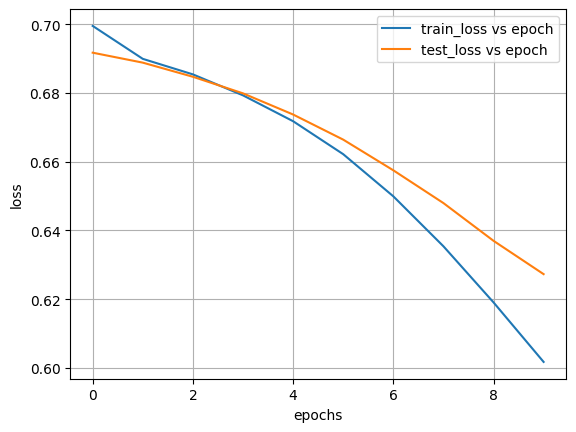

In [17]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

The model appears to be learning effectively, as indicated by the decreasing trend in both training and testing loss. The relatively small gap between training and testing loss suggests that the model is generalizing well to the testing data. For further improvement, the number of epochs could be increased.